# ABC calibration of $I_\text{to}$ in Courtemanche model to original dataset.

In [5]:
import os, tempfile
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC.experiment import setup
from ionchannelABC.visualization import plot_sim_results, plot_kde_matrix_custom
import myokit

In [7]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

## Initial set-up

Load experiments used in the publication:
 - Steady-state activation [Wang1993]
 - Activation time constant [Courtemanche1998]
 - Deactivation time constant [Courtemanche1998]
 - Steady-state inactivation [Wang1993]
 - Inactivation time constant [Courtemanche1998]
 - Recovery time constant [Courtemanche1998]

In [1]:
from experiments.ito_wang import wang_act, wang_inact
from experiments.ito_courtemanche import (courtemanche_act_kin,
                                          courtemanche_inact_kin,
                                          courtemanche_rec,
                                          courtemanche_deact)

INFO:myokit:Loading Myokit version 1.28.3


In [2]:
modelfile = 'models/courtemanche_ito.mmt'

Plot steady-state and tau functions

In [3]:
from ionchannelABC.visualization import plot_variables

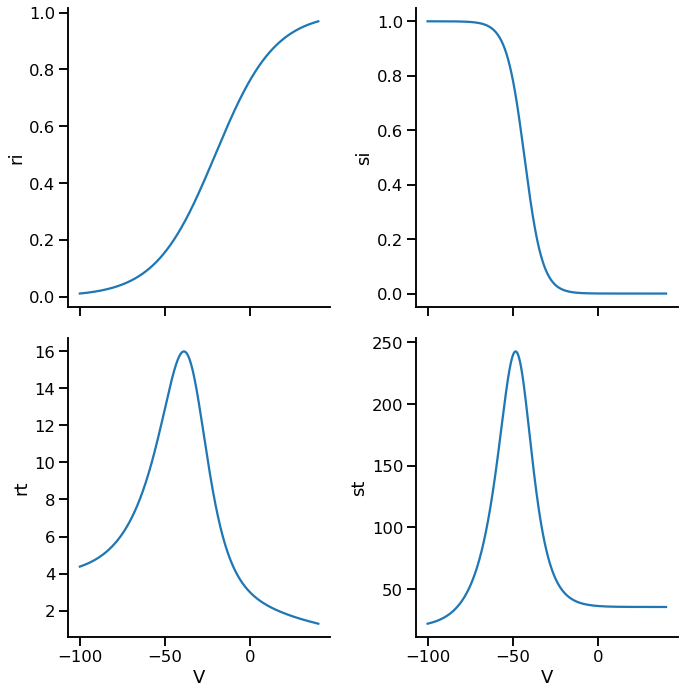

In [8]:
sns.set_context('talk')

V = np.arange(-100, 40, 0.01)

cou_par_map = {'ri': 'ito.a_inf',
            'si': 'ito.i_inf',
            'rt': 'ito.tau_a',
            'st': 'ito.tau_i'}

f, ax = plot_variables(V, cou_par_map, modelfile, figshape=(2,2))

# Activation gate ($a$) calibration

Combine model and experiments to produce:
 - observations dataframe
 - model function to run experiments and return traces
 - summary statistics function to accept traces

In [9]:
observations, model, summary_statistics = setup(modelfile,
                                                wang_act,
                                                courtemanche_act_kin,
                                                courtemanche_deact)

In [10]:
assert len(observations)==len(summary_statistics(model({})))

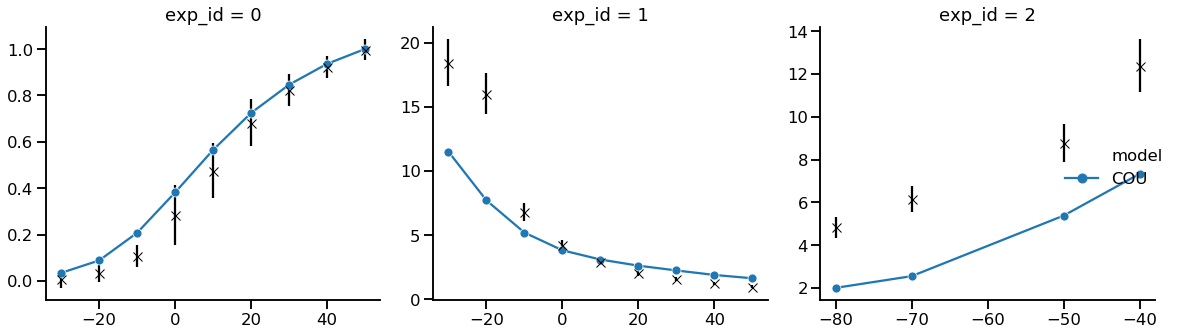

In [11]:
g = plot_sim_results(modelfile,
                     wang_act,
                     courtemanche_act_kin,
                     courtemanche_deact)

### Set up prior ranges for each parameter in the model.

See the modelfile for further information on specific parameters. Prepending `log_' has the effect of setting the parameter in log space.

In [12]:
limits = {'ito.p1': (-100, 100),
          'ito.p2': (1e-7, 50),
          'log_ito.p3': (-3, 2),
          'ito.p4': (-100, 100),
          'ito.p5': (1e-7, 50),
          'ito.p6': (-100, 100),
          'ito.p7': (1e-7, 50),
          'log_ito.p8': (-3, 2),
          'ito.p9': (-100, 100),
          'ito.p10': (1e-7, 50)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [13]:
# Test this works correctly with set-up functions
assert len(observations) == len(summary_statistics(model(prior.rvs())))

### Run ABC calibration

In [12]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "courtemanche_ito_agate_original.db"))

In [13]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [14]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 1024 particles


In [15]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9863674644064488, '1': 0.9863674644064488, '2': 0.9863674644064488, '3': 0.38080068442521287, '4': 0.41009304476561353, '5': 0.48465541654118166, '6': 0.7108279442603979, '7': 0.9863674644064488, '8': 0.9863674644064488, '9': 0.4931837322032244, '10': 0.5675655409945304, '11': 0.9863674644064488, '12': 0.9863674644064488, '13': 0.9863674644064488, '14': 0.9863674644064488, '15': 0.9863674644064488, '16': 0.9863674644064488, '17': 0.9863674644064488, '18': 2.21932679491451, '19': 2.21932679491451, '20': 1.5681470766461805, '21': 1.109663397457255}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [16]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [17]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-10-23 21:42:28.102724, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0


### Analysis of results

In [14]:
history = History('sqlite:///results/courtemanche/ito/original/courtemanche_ito_agate_original.db')

In [17]:
history.all_runs()

[<ABCSMC(id=1, start_time=2019-10-23 21:42:28.102724, end_time=2019-10-24 05:57:58.555764)>]

In [15]:
df, w = history.get_distribution()

In [16]:
df.describe()

name,ito.p1,ito.p10,ito.p2,ito.p4,ito.p5,ito.p6,ito.p7,ito.p9,log_ito.p3,log_ito.p8
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,16.600486,41.592736,18.627438,40.373520,17.409555,35.182060,15.135355,46.334171,-1.332184,-1.215305
std,4.887944,6.504078,2.508583,27.322327,13.630647,24.837648,13.064497,37.086002,0.389039,0.802024
min,2.472425,10.776422,8.705817,-9.434580,0.018765,-8.365178,0.008675,-98.039715,-2.762503,-2.998548
25%,13.033801,38.445318,16.781949,16.666113,5.244241,15.832420,4.411910,25.801936,-1.551135,-1.809568
50%,16.637672,42.991410,18.478613,30.882549,14.109837,24.009644,8.945033,53.084957,-1.275799,-1.155624
75%,20.047887,46.489949,20.310545,63.824844,28.434706,53.900340,25.135711,74.058530,-1.053456,-0.607776
max,31.034488,49.987978,26.860276,99.338457,49.820327,99.905804,49.872902,99.950171,-0.136852,0.898557


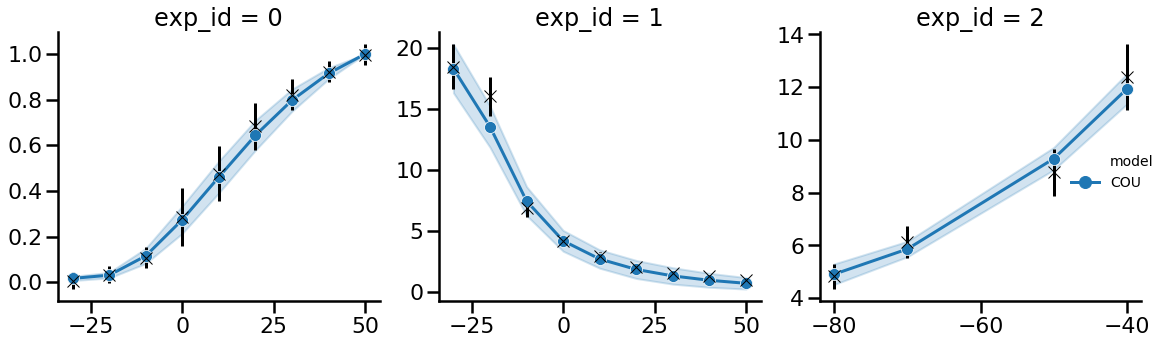

In [18]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile,
                     wang_act,
                     courtemanche_act_kin,
                     courtemanche_deact,
                     df=df, w=w)

plt.tight_layout()

In [19]:
import pandas as pd
N = 100
cou_par_samples = df.sample(n=N, weights=w, replace=True)
cou_par_samples = cou_par_samples.set_index([pd.Index(range(N))])
cou_par_samples = cou_par_samples.to_dict(orient='records')

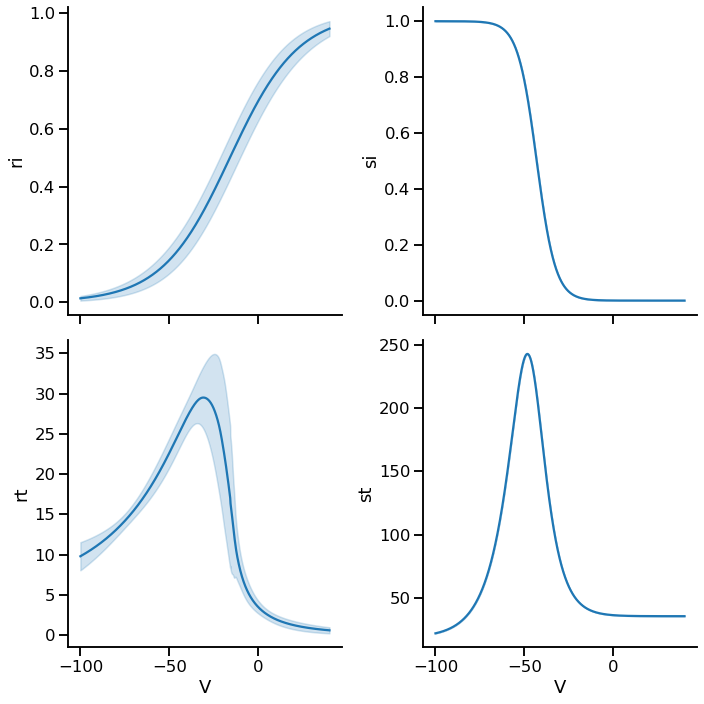

In [20]:
sns.set_context('talk')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, cou_par_map, 
                       'models/courtemanche_ito.mmt', 
                       [cou_par_samples],
                       figshape=(2,2))
plt.tight_layout()

In [21]:
m,_,_ = myokit.load(modelfile)

In [22]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

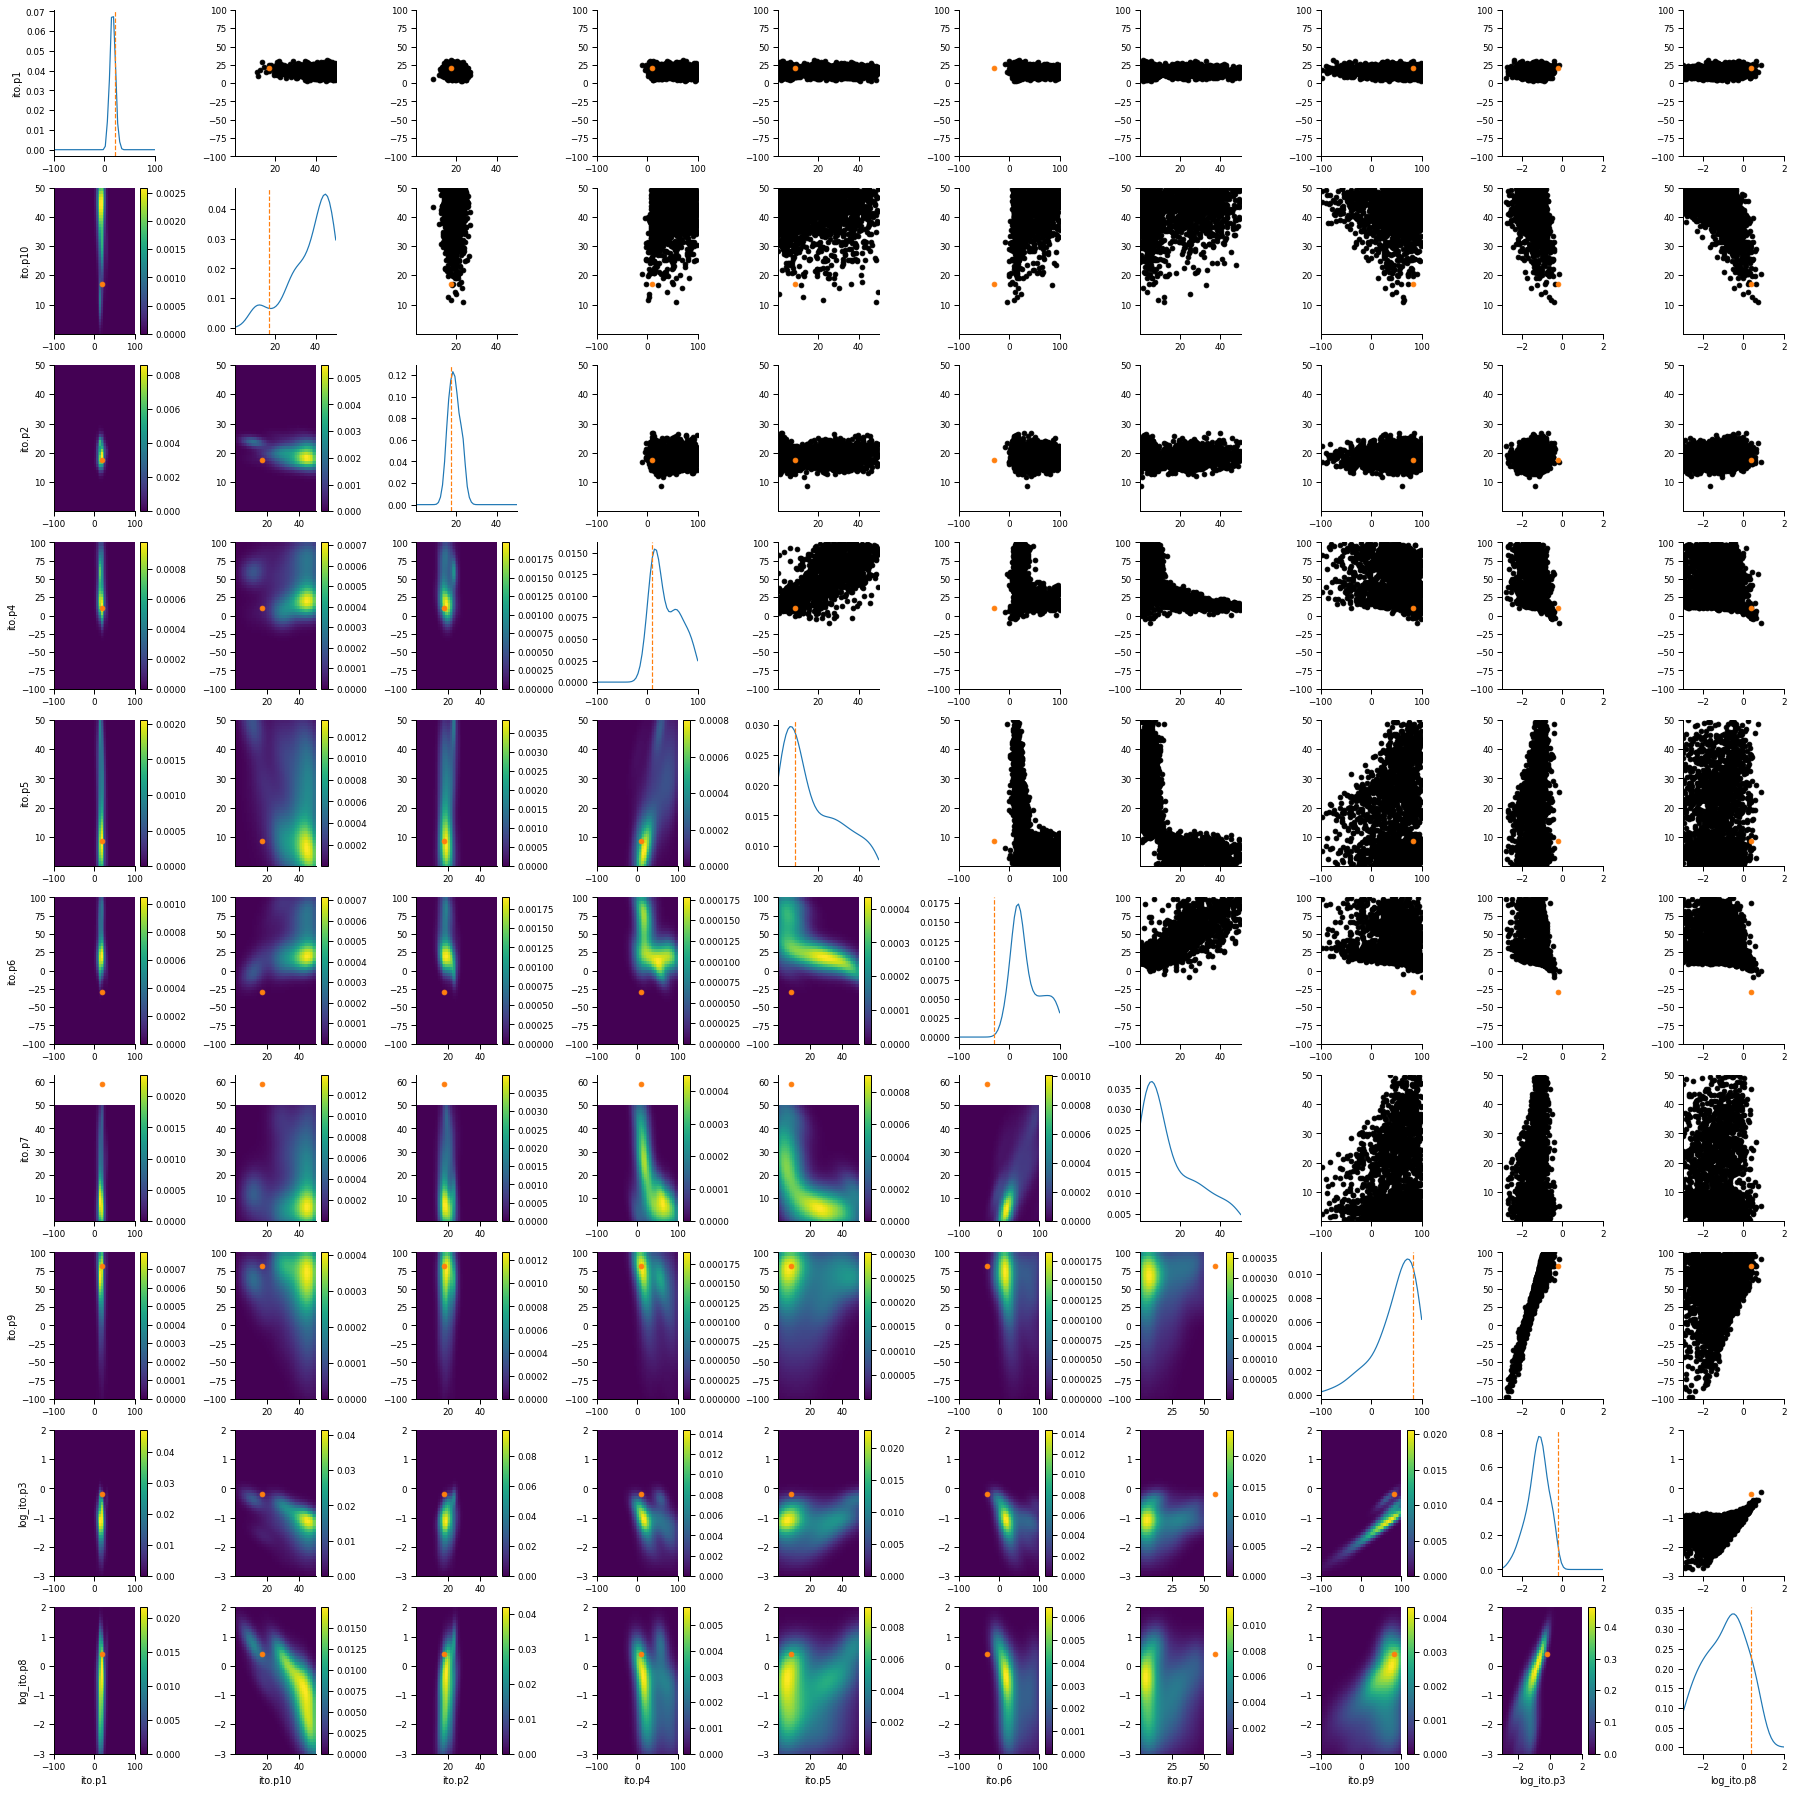

In [23]:
sns.set_context('paper')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)
plt.tight_layout()

# Inactivation gate ($i$) calibration

In [24]:
observations, model, summary_statistics = setup(modelfile,
                                                wang_inact,
                                                courtemanche_inact_kin,
                                                courtemanche_rec)

In [25]:
assert len(observations)==len(summary_statistics(model({})))

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:137: RuntimeWarning: invalid value encountered in true_divide


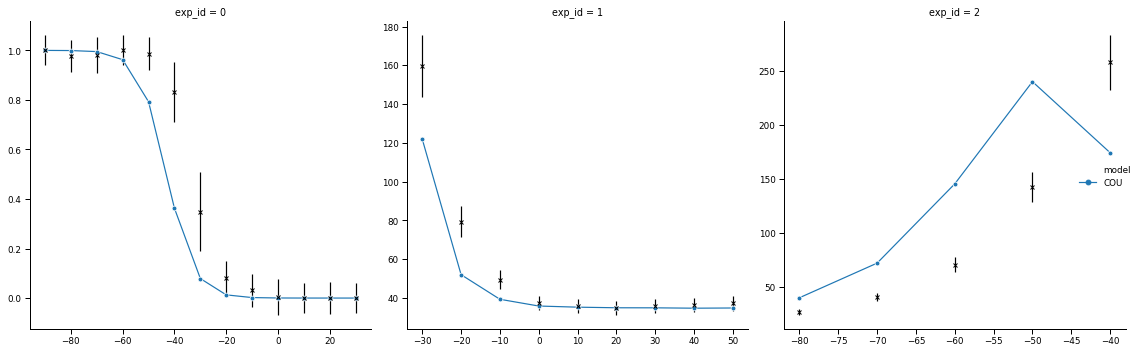

In [26]:
g = plot_sim_results(modelfile,
                     wang_inact,
                     courtemanche_inact_kin,
                     courtemanche_rec)

### Set up prior ranges for each parameter in the model.

See the modelfile for further information on specific parameters. Prepending `log_' has the effect of setting the parameter in log space.

In [37]:
limits = {'ito.q1': (-100, 100),
          'ito.q2': (1e-7, 50),
          'log_ito.q3': (-1, 4),
          'ito.q4': (0, 200),
          'ito.q5': (1e-7, 50),
          'log_ito.q6': (-1, 4),
          'ito.q7': (-100, 100),
          'ito.q8': (1e-7, 50)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [38]:
# Test this works correctly with set-up functions
assert len(observations) == len(summary_statistics(model(prior.rvs())))

### Run ABC calibration

In [44]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "courtemanche_ito_igate_original.db"))

In [45]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 256 particles


In [46]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.6781868948071604, '1': 0.6216713202398976, '2': 0.5738504494522136, '3': 0.6781868948071604, '4': 0.6216713202399009, '5': 0.33909344740358116, '6': 0.25724330492685465, '7': 0.6216713202398976, '8': 0.621671320239904, '9': 0.5738504494522165, '10': 0.6781868948071643, '11': 0.621671320239904, '12': 0.6781868948071643, '13': 0.591589473692273, '14': 1.183178947384546, '15': 1.183178947384546, '16': 1.183178947384546, '17': 1.183178947384546, '18': 1.183178947384546, '19': 1.183178947384546, '20': 1.183178947384546, '21': 1.183178947384546, '22': 2.1297221052921826, '23': 2.1297221052921826, '24': 2.1297221052921826, '25': 1.9238097470457012, '26': 1.0648610526460913}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [47]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [48]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-10-20 08:23:55.815658, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0


### Analysis of results

In [28]:
history = History('sqlite:///results/courtemanche/ito/original/courtemanche_ito_igate_original.db')

In [29]:
df, w = history.get_distribution()

In [30]:
df.describe()

name,ito.q1,ito.q2,ito.q4,ito.q5,ito.q7,ito.q8,log_ito.q3,log_ito.q6
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,33.726506,7.003321,124.914911,15.278618,31.792600,0.699132,0.382921,1.584109
std,1.083318,0.812193,6.929686,1.336291,4.560068,0.784947,0.594693,0.020798
min,29.529337,0.503139,83.256367,6.771096,-8.389219,0.000812,-0.997456,1.551838
25%,33.132205,6.676952,122.275521,14.821803,30.174285,0.305148,-0.045907,1.569514
50%,33.803978,7.144397,126.394782,15.556375,31.873440,0.596787,0.489783,1.576448
75%,34.411783,7.474120,129.331385,16.101102,33.848735,0.927740,0.872158,1.589069
max,39.176830,8.174815,136.871518,17.584511,39.687855,8.045679,1.517183,1.643278


/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:137: RuntimeWarning: invalid value encountered in true_divide


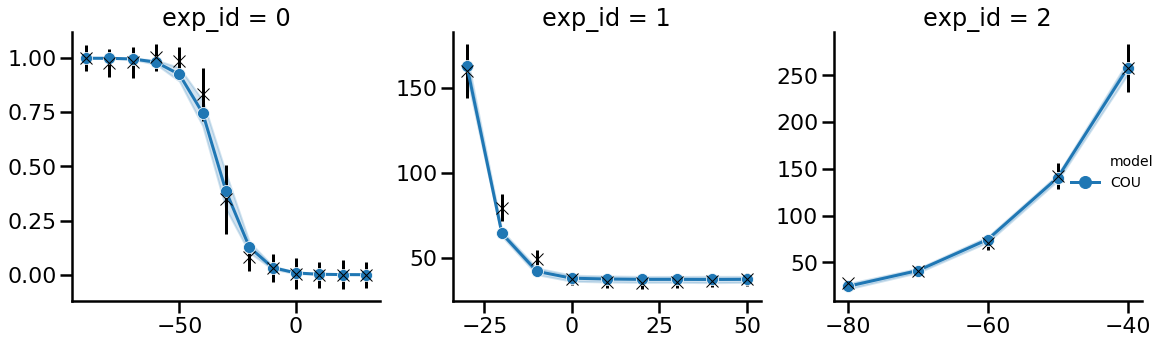

In [31]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile,
                     wang_inact,
                     courtemanche_inact_kin,
                     courtemanche_rec,
                     df=df, w=w)

plt.tight_layout()

In [32]:
N = 100
cou_par_samples = df.sample(n=N, weights=w, replace=True)
cou_par_samples = cou_par_samples.set_index([pd.Index(range(N))])
cou_par_samples = cou_par_samples.to_dict(orient='records')

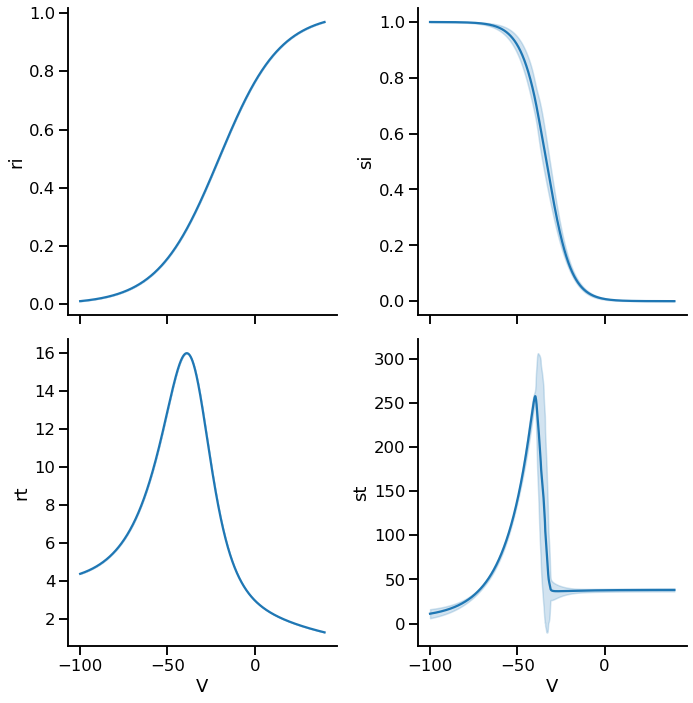

In [33]:
sns.set_context('talk')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, cou_par_map, 
                       'models/courtemanche_ito.mmt', 
                       [cou_par_samples],
                       figshape=(2,2))

In [39]:
m,_,_ = myokit.load(modelfile)

In [40]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

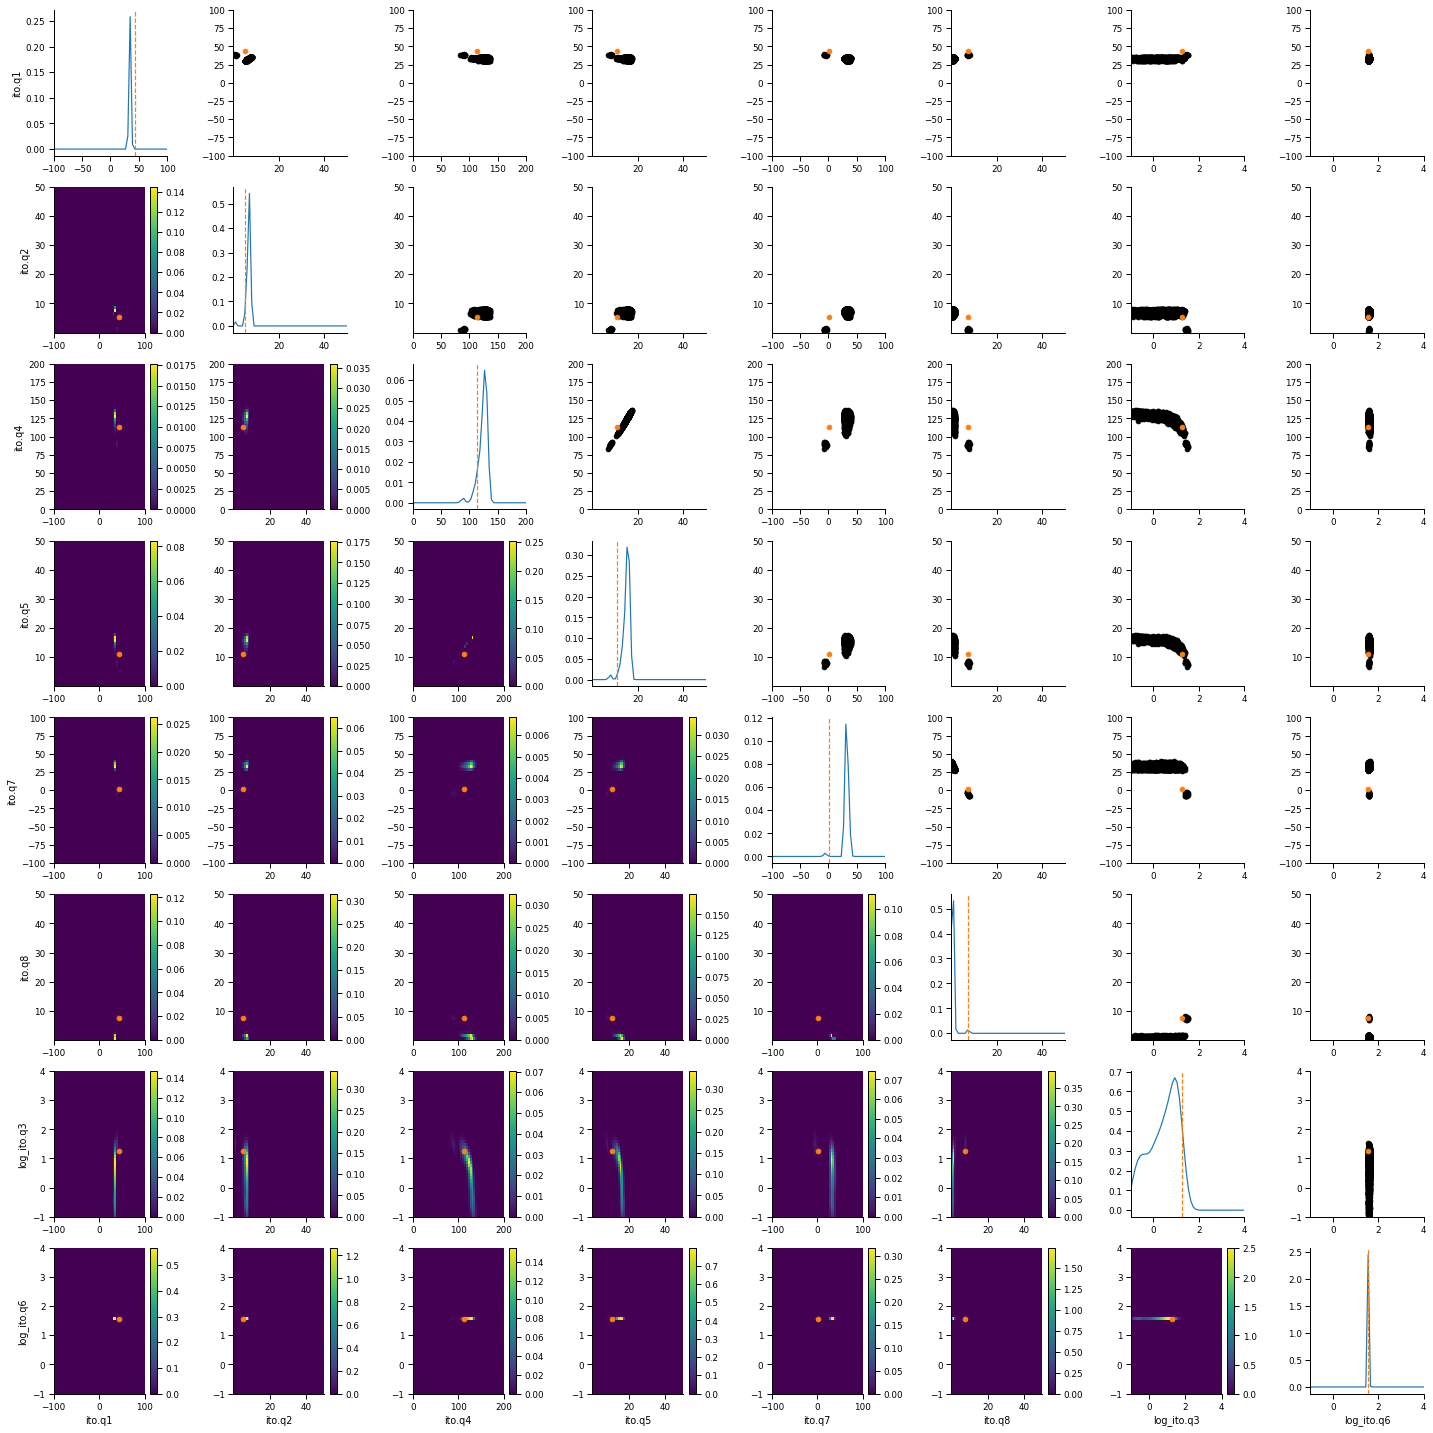

In [41]:
sns.set_context('paper')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)
plt.tight_layout()